In [1]:
import mlflow
import torch
import torch.nn as nn
from torchmetrics.segmentation import DiceScore 
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, DeepLabV3_MobileNet_V3_Large_Weights
import lightning as L
from terratorch.cli_tools import LightningInferenceModel
import matplotlib.pyplot as plt
import numpy as np

In [2]:
CONFIG = "configs/burn_scars_config.yaml"
CHECKPOINT = "teachers/Prithvi_EO_V2_300M_BurnScars.pt"

In [3]:
inference_model = LightningInferenceModel.from_config(CONFIG, CHECKPOINT)
teacher = inference_model.model
datamodule = inference_model.datamodule

/home/mateusz/Desktop/university/thesis/distilprithvi/venv/lib/python3.11/site-packages/lightning/pytorch/cli.py:530: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--f=/run/user/1000/jupyter/runtime/kernel-v34139162d15361f8d75d69c1e9c940ba7e7b08826.json'], args=['--config', 'configs/burn_scars_config.yaml'].
Seed set to 2
INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed
/home/mateusz/Desktop/university/thesis/distilprithvi/venv/lib

In [4]:
class Student(nn.Module):
    def __init__(self, num_channels, num_classes):
        super().__init__()
        self.model = deeplabv3_mobilenet_v3_large(
            weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT,
        )
        self.model.backbone["0"][0] = nn.Conv2d(
            num_channels, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
        )
        self.model.classifier[4] = nn.Conv2d(
            256, num_classes, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=True
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
class DistilPrithvi(L.LightningModule):
    def __init__(
        self,
        teacher,
        student,
        aug,
        soft_loss_weight=1.0,
    ):
        super().__init__()
        self.teacher = teacher
        self.teacher.eval()
        self.teacher.requires_grad = False

        self.student = student
        # self.soft_loss_func = nn.BCEWithLogitsLoss()
        
        self.hard_loss_func = nn.CrossEntropyLoss()

        self.soft_loss_weight = soft_loss_weight

        self.aug = aug

    def forward(self, x):
        return self.student(x)["out"]

    def step(self, batch, stage):
        # TODO: Might not be needed when training
        # x = self.aug(batch)["image"] 

        # TODO: used in the inference demo, idk why
        if x.mean() > 1:
            x = x / 10000

        y = batch["mask"]
        y[y < 0] = 1  # interpret [no info] as [burn]

        y_hat_s = self.student(x)["out"]

        loss = self.hard_loss_func(y_hat_s, y)
        self.log(f"{stage}_loss", loss, on_epoch=True)

        return loss

    def training_step(self, batch):
        return self.step(batch, "train")

    def validation_step(self, batch):
        return self.step(batch, "val")

    def test_step(self, batch):
        return self.step(batch, "test")

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

In [6]:
distilprithvi = DistilPrithvi(
    teacher=teacher,
    student=Student(6, 2),
    aug=datamodule.aug,
    soft_loss_weight=0.0,
)

In [7]:
trainer = L.Trainer(
    max_epochs=100,
    log_every_n_steps=1,
    val_check_interval=0.5,
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [14]:
mlflow.pytorch.autolog()

with mlflow.start_run():
    trainer.fit(
        distilprithvi,
        datamodule,
    )
    trainer.test(
        distilprithvi,
        datamodule,
    )

2025/04/24 21:02:13 WARNING mlflow.utils.autologging_utils: MLflow pytorch autologging is known to be compatible with 1.9.0 <= torch <= 2.6.0, but the installed version is 2.6.0+cu124. If you encounter errors during autologging, try upgrading / downgrading torch to a compatible version, or try upgrading MLflow.
2025/04/24 21:02:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mateusz/Desktop/university/thesis/distilprithvi/venv/lib/python3.11/site-packages/mlflow/pytorch/_lightning_autolog.py:465: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.9.0 and 2.5.0.post0 and may not succeed with packages outside this range."

  | Name           | Type                     | Params | Mode 
--------------------------------------------------------------------
0 | teacher        | SemanticSegmentationTask | 324 M  | eval 
1 | student        | Student                  | 11.0 M | train
2 | hard_loss_func | CrossE

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mateusz/Desktop/university/thesis/distilprithvi/venv/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [8]:
import os
from typing import List, Union
import re
import datetime
import numpy as np
import rasterio
import torch
import yaml
from einops import rearrange
from terratorch.cli_tools import LightningInferenceModel

NO_DATA = -9999
NO_DATA_FLOAT = 0.0001
OFFSET = 0
PERCENTILE = 99


def process_channel_group(orig_img, channels):
    """
    Args:
        orig_img: torch.Tensor representing original image (reference) with shape = (bands, H, W).
        channels: list of indices representing RGB channels.

    Returns:
        torch.Tensor with shape (num_channels, height, width) for original image
    """

    orig_img = orig_img[channels, ...]
    valid_mask = torch.ones_like(orig_img, dtype=torch.bool)
    valid_mask[orig_img == NO_DATA_FLOAT] = False

    # Rescale (enhancing contrast)
    max_value = max(3000, np.percentile(orig_img[valid_mask], PERCENTILE))
    min_value = OFFSET

    orig_img = torch.clamp((orig_img - min_value) / (max_value - min_value), 0, 1)

    # No data as zeros
    orig_img[~valid_mask] = 0

    return orig_img


def read_geotiff(file_path: str):
    """Read all bands from *file_path* and return image + meta info.

    Args:
        file_path: path to image file.

    Returns:
        np.ndarray with shape (bands, height, width)
        meta info dict
    """

    with rasterio.open(file_path) as src:
        img = src.read()
        meta = src.meta
        try:
            coords = src.lnglat()
        except:
            # Cannot read coords
            coords = None

    return img, meta, coords


def save_geotiff(image, output_path: str, meta: dict):
    """Save multi-band image in Geotiff file.

    Args:
        image: np.ndarray with shape (bands, height, width)
        output_path: path where to save the image
        meta: dict with meta info.
    """

    with rasterio.open(output_path, "w", **meta) as dest:
        for i in range(image.shape[0]):
            dest.write(image[i, :, :], i + 1)

    return


def _convert_np_uint8(float_image: torch.Tensor):
    image = float_image.numpy() * 255.0
    image = image.astype(dtype=np.uint8)

    return image


def load_example(
    file_paths: List[str],
    mean: List[float] = None,
    std: List[float] = None,
    indices: Union[list[int], None] = None,
):
    """Build an input example by loading images in *file_paths*.

    Args:
        file_paths: list of file paths .
        mean: list containing mean values for each band in the images in *file_paths*.
        std: list containing std values for each band in the images in *file_paths*.

    Returns:
        np.array containing created example
        list of meta info for each image in *file_paths*
    """

    imgs = []
    metas = []
    temporal_coords = []
    location_coords = []

    for file in file_paths:
        img, meta, coords = read_geotiff(file)

        # Rescaling (don't normalize on nodata)
        img = np.moveaxis(img, 0, -1)  # channels last for rescaling
        if indices is not None:
            img = img[..., indices]
        if mean is not None and std is not None:
            img = np.where(img == NO_DATA, NO_DATA_FLOAT, (img - mean) / std)

        imgs.append(img)
        metas.append(meta)
        if coords is not None:
            location_coords.append(coords)

        try:
            match = re.search(r"(\d{7,8}T\d{6})", file)
            if match:
                year = int(match.group(1)[:4])
                julian_day = match.group(1).split("T")[0][4:]
                if len(julian_day) == 3:
                    julian_day = int(julian_day)
                else:
                    julian_day = (
                        datetime.datetime.strptime(julian_day, "%m%d")
                        .timetuple()
                        .tm_yday
                    )
                temporal_coords.append([year, julian_day])
        except Exception as e:
            print(f"Could not extract timestamp for {file} ({e})")

    imgs = np.stack(imgs, axis=0)  # num_frames, H, W, C
    imgs = np.moveaxis(imgs, -1, 0).astype("float32")  # C, num_frames, H, W
    imgs = np.expand_dims(imgs, axis=0)  # add batch di

    return imgs, temporal_coords, location_coords, metas


def run_model(input_data, model, datamodule, img_size):
    # Reflect pad if not divisible by img_size
    original_h, original_w = input_data.shape[-2:]
    pad_h = (img_size - (original_h % img_size)) % img_size
    pad_w = (img_size - (original_w % img_size)) % img_size
    input_data = np.pad(
        input_data, ((0, 0), (0, 0), (0, 0), (0, pad_h), (0, pad_w)), mode="reflect"
    )

    # Build sliding window

    batch_size = 1
    batch = torch.tensor(input_data, device="cpu")
    windows = batch.unfold(3, img_size, img_size).unfold(4, img_size, img_size)
    h1, w1 = windows.shape[3:5]
    windows = rearrange(
        windows, "b c t h1 w1 h w -> (b h1 w1) c t h w", h=img_size, w=img_size
    )

    # Split into batches if number of windows > batch_size
    num_batches = windows.shape[0] // batch_size if windows.shape[0] > batch_size else 1
    windows = torch.tensor_split(windows, num_batches, dim=0)

    # Run model
    pred_imgs = []
    for x in windows:
        # Apply standardization
        x = datamodule.test_transform(image=x.squeeze().numpy().transpose(1, 2, 0))
        x["image"] = x["image"].unsqueeze(0)
        x = datamodule.aug(x)["image"]

        with torch.no_grad():
            x = x.to(model.device)
            pred = model(x)
            pred = pred.output.detach().cpu()

        y_hat = pred.argmax(dim=1)

        y_hat = torch.nn.functional.interpolate(
            y_hat.unsqueeze(1).float(), size=img_size, mode="nearest"
        )

        pred_imgs.append(y_hat)

    pred_imgs = torch.concat(pred_imgs, dim=0)

    # Build images from patches
    pred_imgs = rearrange(
        pred_imgs,
        "(b h1 w1) c h w -> b c (h1 h) (w1 w)",
        h=img_size,
        w=img_size,
        b=1,
        c=1,
        h1=h1,
        w1=w1,
    )

    # Cut padded area back to original size
    pred_imgs = pred_imgs[..., :original_h, :original_w]

    # Squeeze (batch size 1)
    pred_imgs = pred_imgs[0]

    return pred_imgs


def main(
    data_file: str,
    config: str,
    checkpoint: str,
    output_dir: str,
    rgb_outputs: bool,
    input_indices: list[int] = None,
):
    os.makedirs(output_dir, exist_ok=True)

    with open(config, "r") as f:
        config_dict = yaml.safe_load(f)

    # Load model ---------------------------------------------------------------------------------

    lightning_model = LightningInferenceModel.from_config(config, checkpoint)
    img_size = 512  # Size of BurnScars

    # Loading data ---------------------------------------------------------------------------------

    input_data, temporal_coords, location_coords, meta_data = load_example(
        file_paths=[data_file],
        indices=input_indices,
    )

    meta_data = meta_data[0]  # only one image

    if input_data.mean() > 1:
        input_data = input_data / 10000  # Convert to range 0-1

    # Running model --------------------------------------------------------------------------------
    print(input_data.shape)

    lightning_model.model.eval()

    channels = config_dict["data"]["init_args"]["rgb_indices"]

    pred = run_model(
        input_data, lightning_model.model, lightning_model.datamodule, img_size
    )
    display_mask(pred.squeeze(0).squeeze(0))

In [9]:
def run_model_(x, model, datamodule):

    n = {}
    n["image"] = x
    x = datamodule.aug(n)["image"]

    pred = model(x)
    pred = pred.output

    y_hat = pred.argmax(dim=1)

    return y_hat


def display_mask(x):
    plt.imshow(x, cmap="gray")
    plt.axis("off")
    plt.show()

torch.Size([6, 512, 512])


/home/mateusz/Desktop/university/thesis/distilprithvi/venv/lib/python3.11/site-packages/lightning/pytorch/cli.py:530: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--f=/run/user/1000/jupyter/runtime/kernel-v34139162d15361f8d75d69c1e9c940ba7e7b08826.json'], args=['--config', 'configs/burn_scars_config.yaml'].
Seed set to 2
INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed
/home/mateusz/Desktop/university/thesis/distilprithvi/venv/lib

(1, 6, 1, 512, 512)


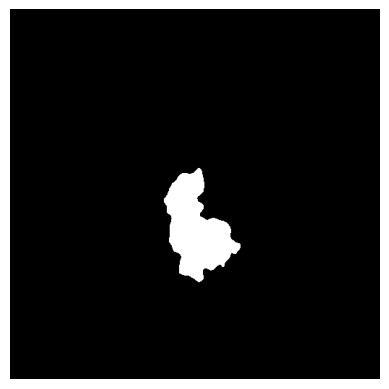

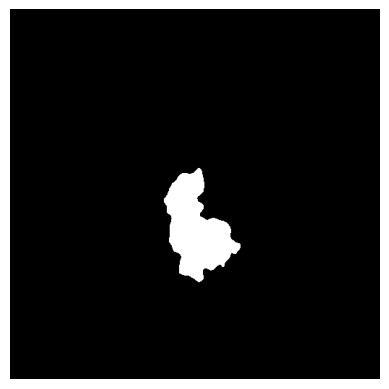

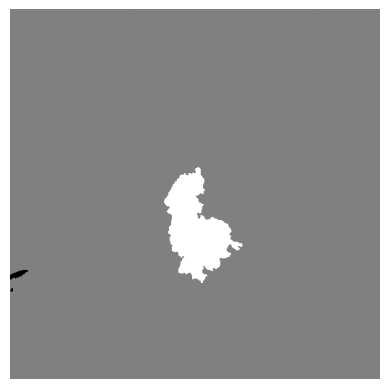

In [13]:
torch.seed()
teacher.eval()
datamodule.setup("test")
idx = torch.randint(0, len(datamodule.test_dataset), (1,)).item()
input_data = datamodule.test_dataset[idx]["image"]
mask = datamodule.test_dataset[idx]["mask"]
filename = datamodule.test_dataset[idx]["filename"]
print(input_data.shape)
input_data = input_data.unsqueeze(1).unsqueeze(0)

if input_data.mean() > 1:
    input_data = input_data / 10000  # Convert to range 0-1

pred = run_model_(
    input_data,
    teacher,
    datamodule,
)

main(
    data_file=filename,
    config="configs/burn_scars_config.yaml",
    checkpoint="teachers/Prithvi_EO_V2_300M_BurnScars.pt",
    output_dir="output",
    rgb_outputs=False,
    input_indices=[0, 1, 2, 3, 4, 5],
)
display_mask(pred.squeeze(0).squeeze(0))
display_mask(mask.squeeze(0).squeeze(0))